In [ ]:
import tensorflow as tf
import keras as k
from tensorflow.keras import datasets,models, layers,datasets
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"anjalimuramkar","key":"c2103e61bf585aa5038421cb8dd3de08"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download sohaibalam67/potato-disease

 99% 75.0M/75.7M [00:00<00:00, 212MB/s]
100% 75.7M/75.7M [00:00<00:00, 193MB/s]


In [ ]:
! unzip potato-disease

Archive:  potato-disease.zip
  inflating: Potato/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: Potato/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: Potato/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: Potato/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: Potato/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: Potato/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: Potato/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: Potato/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG  
  inflating: Potato/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG  
  inflating: Potato/Potato___Early_blight/03

In [ ]:
Image_size=224
Batch_size=32
channel=3
epochs=5

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "../content/Potato",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size,
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

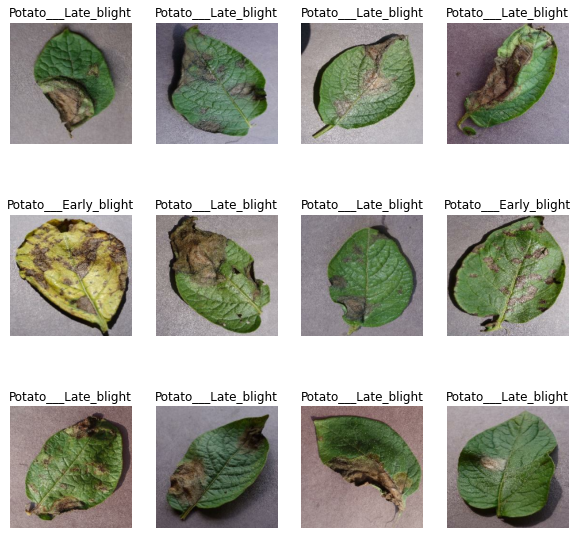

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
train_size=0.8
train_ds=dataset.take(54)

In [ ]:
val_ds=dataset.skip(54).take(6)
len(val_ds)

6

In [ ]:
test_ds=dataset.skip(54).skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(Image_size,Image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow_hub as hub
extractor="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pre_model=hub.KerasLayer(extractor, input_shape=(None,224,224,3),trainable=False)

In [ ]:
for image_batch, label_batch in train_ds.take(1):
        print(image_batch[0].numpy().shape)


(224, 224, 3)


In [ ]:
input_shape = (Batch_size, Image_size, Image_size, channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    pre_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 keras_layer (KerasLayer)    (32, 1280)                2257984   
                                                                 
 dense (Dense)               (32, 64)                  81984     
                                                                 
 dense_1 (Dense)             (32, 32)                  2080      
                                                                 
 dense_2 (Dense)             (32, 3)                   99        
                                                                 
Total params: 2,342,147
Trainable params: 84,163
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=3,
)

RuntimeError: ignored

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 11s 925ms/step - loss: 0.0666 - accuracy: 0.9766


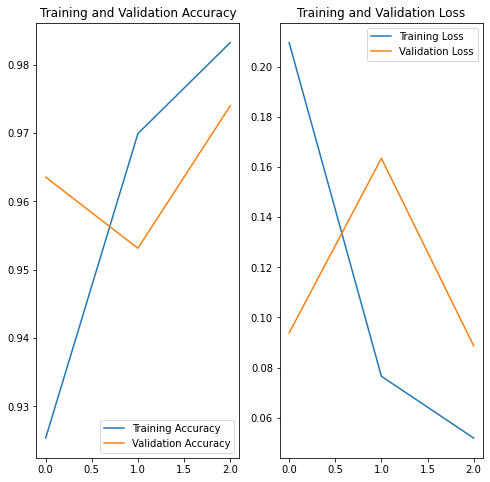

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(3), acc, label='Training Accuracy')
plt.plot(range(3), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(3), loss, label='Training Loss')
plt.plot(range(3), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 59ms/step


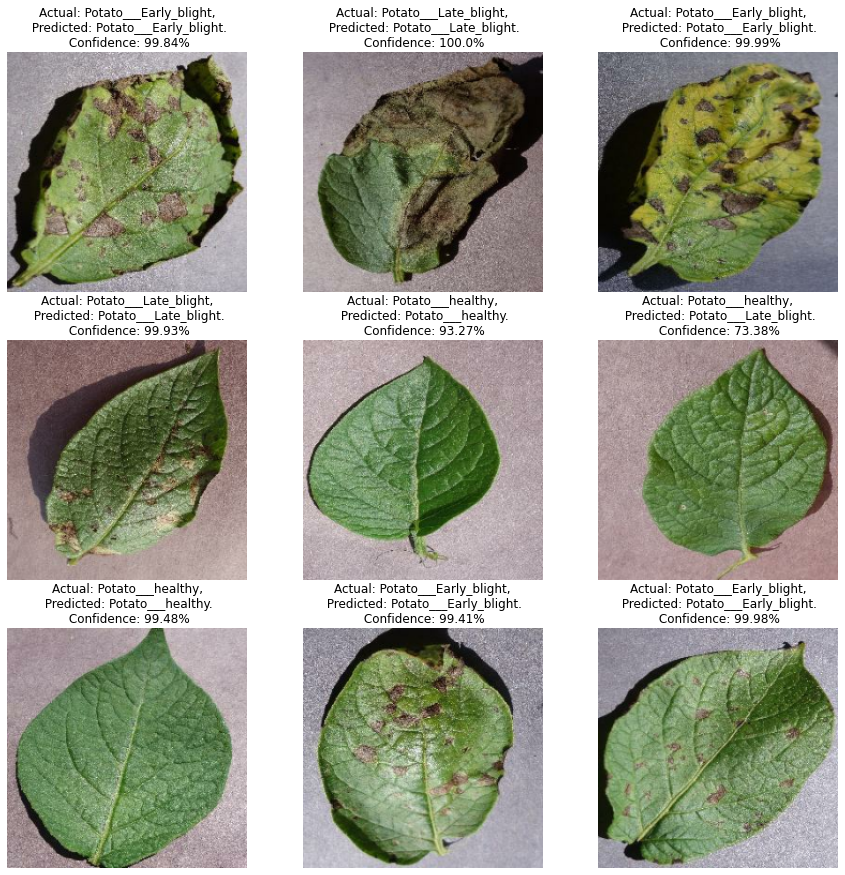

In [ ]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")